# Simulating the Dilution Experiment and Estimating $\alpha$

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tools.numdiff as nd
import scipy.stats
import pandas as pd
import mscl.plotting
mscl.plotting.set_plotting_style()
%matplotlib inline

## Deriving the prediction

Imagine we have a cell that has a fixed number of fluorescent proteins. as this cell divides, these proteins will be Binomially partitioned into the two daughter cells. If all protein production is ceased and degradation is halted (or the proteins have a very long half life), the fluorescent signal of lineage will decrease as the cells divide until the fluorescence is indistiguishable from the autofluorescent background. 

We can use the fluctuations in fluorescence intensity between any two daughter cells to determine just how bright a single fluorescent protein is in arbitrary units, and use that calibration factor to count protein copy number in single cells. 

For this derivation, we will assume that the fluroescence is conserved between a mother and its daughter cells, 

$$
I_\text{tot} = I_1 + I_2, 
\tag{1}
$$

where the fluorescence of the mother cell is $I_\text{tot}$ and the fluorescence for the two daughter cells are $I_1$ and $I_2$. The intensity of a given cell is dependent on the total number of fluorescent proteins in that cell, 

$$
I_\text{tot} = \alpha N_\text{tot},
\tag{2}
$$

where $N_\text{tot}$ is the number of fluorescent proteins in a given mother cell and $\alpha$ is the fluorescence calibration factor of a single fluorescent protein in arbitrary units.  If we assume that there is no production or degradation of the fluorescent proteins as cells undergo division, we can say that the total number of proteins should be conserved (just as in Eq. 1),

$$
N_\text{tot} = N_1 + N_2.
\tag{3}
$$

As a cell undergoes division, the cellular contents must be split between the two daughter cells. With a finite pool of fluorescent proteins, we know that the distribution of proteins into the two daughter cells is Binomial, 

$$
P(n\, \vert\, N_\text{tot}, p) = {N_\text{tot}! \over n!(N_\text{tot} - n)!}p^n(1-p)^{N_\text{tot} - n},
\tag{4}
$$.

where $p$ is the probability of a protein ending up in one daughter cell relative to the other, and $n$ is the number of proteins split into either daughter. We can make the simplifying assumption that a protein has a fair chance of ending up in either daughter cell, we can write Eq. 4 as 

$$
P(n, \vert N_\text{tot}) = {N_\text{tot}! \over n!(N_\text{tot} - n)!}2^{-N_\text{tot}}.
\tag{5}
$$

To count the number of proteins in a cell and estimate the value of the calibration factor, we need to look at the fluctuations of intensity between the two daughter cells, 

$$
\langle (I_1 - I_2)^2 \rangle = \langle(2I_1 - I_\text{tot})^2\rangle.
\tag{6}
$$


Using the relationship stated in Eq. 2, we can rewrite Eq. 6 as

$$
\begin{align}
\langle(I_1 - I_2)^2\rangle &= \langle(2\alpha N_1 - \alpha N_\text{tot})^2 \rangle\\
&= 4 \alpha^2\langle N_1^2\rangle - 4\alpha^2\langle N_1 \rangle N_\text{tot} + \alpha^2 N_\text{tot}^2.
\tag{7}
\end{align}
$$

As we know the distribution of proteins into one of the daughter cells is Binomial (as show in Eq. 4), we know how to calculate the quantitites $\langle N_1 \rangle$^2 and $\langle N_1^2\rangle$. The average copy number is given by

$$
\langle N_1 \rangle = {N_\text{tot} \over 2}
\tag{8}
$$

and the variance $\sigma^2$ is

$$
\sigma^2 = \langle N_1^2 \rangle - \langle N_1 \rangle^2 = {N_\text{tot} \over 4},
\tag{9}
$$

Solving Eq. 9 for $\langle N_1^2 \rangle$ and using Eq. 8 for $\langle N_1 \rangle$, we can rewrite Eq. 7 as 

$$
\begin{align}
\langle (I_1 - I_2)^2 \rangle &= {4\alpha^2(N_\text{tot} - N_\text{tot}^2) \over 4} - {4 \alpha^2N_\text{tot}^2 \over 2} + \alpha^2 N_\text{tot}^2\\
&= \alpha^2 N_\text{tot}.
\end{align}
\tag{10}
$$

Eq. 10 simplifies to the beautiful result,

$$
\langle (I_1  - I_2)^2 \rangle = \alpha^2 N_\text{tot} = \alpha I_\text{tot}
\tag{11}.
$$

By knowing the flucutations between two daughter cells, we can figure out how bright a single fluorophore is!


## Performing the simulation

To see that Eq. 11 holds true (and to test our method of estimating $\alpha$ later on), we can simulate this experiment with a *known* value for the calibration factor $\alpha$. To keep the simulation close to experimental reality, we will assume that there is noise in the measurement of the intensity.

In [254]:
# Define the total number of division events
num_div = 500 

# Set the calibration factor.
alpha_seed = 100

# Set the number of proteins for each mother cell. Gamma dist is a good approximation for bursty expression.
n_tot = np.random.gamma(5, 25, size=num_div).astype(int)

# Partition the proteins into daughter cells.
n_1 = np.random.binomial(n_tot, p=0.5)
n_2 = n_tot - n_1

# Use the calibration factor to make intensity with some noise.
I_1 = alpha_seed * n_1 + np.random.normal(0, 100, size=num_div)
I_2 = alpha_seed * n_2 + np.random.normal(0, 100, size=num_div)

# Assemble all of the information into a dataframe.
df = pd.DataFrame(np.array([n_1, n_2, I_1, I_2]).T, 
                  columns=['n_1', 'n_2', 'I_1', 'I_2'])

Now, we can compute the square difference of the daughter cells and plot it as a function of the sum. We'll also add the theoretical prediction $\langle (I_1 - I_2)^2 \rangle = \alpha I_\text{tot}$.

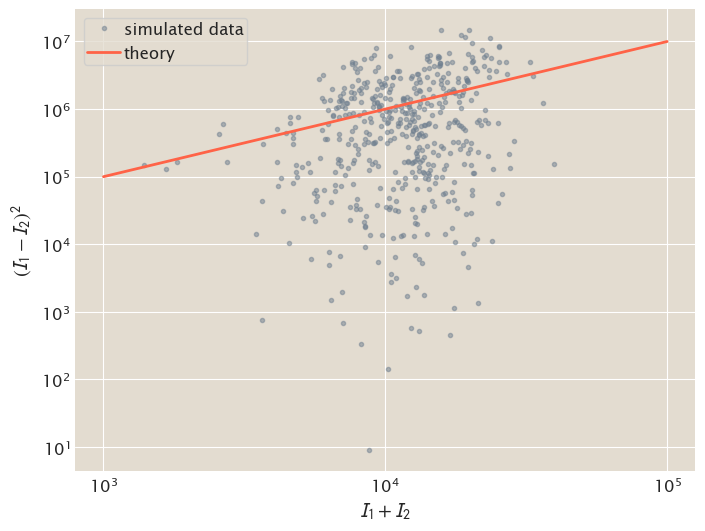

In [255]:
# Compute the square difference and the sum.
sq_diff = (df['I_1'] - df['I_2'])**2
summed = df['I_1'] + df['I_2']

# Add them to the data frame.
df['square_diff'] = sq_diff
df['summed_int'] = summed

# Compute the prediction.
I_tot_range = np.logspace(3, 5, 100)
theo = alpha_seed * I_tot_range

# Plot the data and the prediction.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$')
ax.set_ylabel('$(I_1 - I_2)^2$')
_ = ax.plot(summed, sq_diff, '.', color='slategray', alpha=0.5, 
           label='simulated data')
_ = ax.plot(I_tot_range, theo, '-', color='tomato', lw=2, label='theory')

# Add a legend.
_ = ax.legend()


Our theory predicts the *mean* squared difference. The scatter about the theory curve should not be concerning. We can bin our data by ~50 events each (an arbitrary choice) and compute the mean to better test the agreement.  

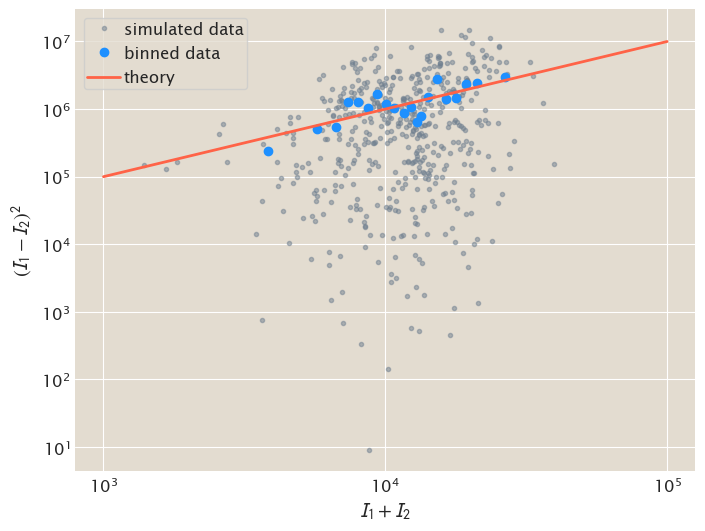

In [307]:
# Sort the data. 
sorted_data = df.sort_values(by='summed_int')

# Bin the data by 50 events. 
bin_width = 25
bins = np.arange(0, len(sorted_data) + bin_width, bin_width)

# Loop through the data and compute the means.
mean_sq_diff = np.array([np.mean((sorted_data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         sorted_data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))])
mean_summed = np.array([np.mean(sorted_data.iloc[bins[i-1]:bins[i]+1]['I_1'] +\
                       sorted_data.iloc[bins[i-1]:bins[i]+1]['I_2']) for i in range(1, len(bins))])

# Set up the figure canvas
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$')
ax.set_ylabel('$(I_1 - I_2)^2$')

# Plot the data. 
_ = ax.plot(df['summed_int'], df['square_diff'], '.', color='slategray', 
            alpha=0.5, label='simulated data')
_ = ax.plot(mean_summed, mean_sq_diff, 'o', color='dodgerblue', label='binned data')
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='theory')
_ = ax.legend()


The theory does a very nice job of predicting the mean value. With this *in silico* confirmation of our theory, we can move on to estimating the calibration factor. 

## Estimating the calibration factor

### Binning and linear regression 

In [308]:
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='summed_int')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((sorted_data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         sorted_data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_sum = [np.mean(sorted_data.iloc[bins[i-1]:bins[i]+1]['I_1'] +\
                       sorted_data.iloc[bins[i-1]:bins[i]+1]['I_2']) for i in range(1, len(bins))]
    
    return [np.array(mean_sq_diff), np.array(mean_sum)] 

With binned data, we can determine the calibration factor as was performed in [Brewster et al. 2014], where they would perform bootstrapping on the binned data to get an estimate of the error. This boils down to a simple linear regression of Eq. 11. Using a Bayesian definition of probability, we can write down the poseterior for our best estimate of $\alpha$,

$$
P(\alpha \, \vert I_\text{tot}) \propto P(I_\text{tot} \, \vert\, \alpha) P(\alpha).
\tag{12}
$$

For the likelihood, it is reasonable to assume that the mean binned data will be Normally distributed about our prediction,

$$
P(\alpha, \sigma \, \vert \, I_\text{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}{1 \over \sigma^k}\exp\left[-\sum\limits_{i}^k (\alpha I_{\text{tot},i} - \alpha^*I_{\text{tot},i})^2\right]
\tag{13}
$$

where $k$ is the number of cell divisions in the data set and $\alpha^*$ is the best-estimate value of the calibration. We can assume maximally uniformative priors for $\alpha$ and $\sigma$,

$$
P(\alpha) = \begin{cases}(\alpha_\text{max} - \alpha_\text{min})^{-1} &  \alpha_\text{min} \leq \alpha \leq \alpha_\text{max}\\
0 & \text{otherwise}\\
\end{cases},
\tag{14}
$$

and 

$$
P(\sigma) = {1 \over sigma}.
$$

For now, we will treat the prior for $\alpha$ as improper and will leave it out of our calculation of the posterior. Our posterior can now be written as

$$
P(\alpha, \sigma \, \vert \, [I_\text{tot}]) \propto {1 \over \sigma^{k + 1}}{1 \over \sqrt{2\pi \sigma^2}}\exp\left[-\sum\limits_i^k(\alpha I_{\text{tot}, i} - \alpha^* I_{\text{tot}, i})^2\right].
\tag{15}
$$

We can remove $\sigma$ as a nuiscance parameter by marginalizing the posterior,

$$
P(\alpha \, \vert \, [I_\text{tot}]) = \int\limits_0^\infty P(\alpha, \sigma \, \vert \, [I_\text{tot}]).
\tag{16}
$$

While this integral is a bit gnarly, the result is very well characterized and is the Student's t distribution,

$$
P(\alpha \vert \, [I_\text{tot}]) \propto \left(\sum\limits_i^k(\alpha I_{\text{tot}, i} - \alpha^*I_{\text{tot}, i})^2\right)^{-k/2}.
\tag{17}
$$

With Eq. 17 as our posterior, we can estimate the best-fit parameter by minimization. Below, we define a function that calculates the log of the posterior.

In [309]:
def log_posterior(alpha, sq_diff, summed_int, neg=True):
    """
    Computes the log posterior distribution for linear regression.
    
    Parameters
    ----------
    alpha : float
        Value of the calibration factor in arbitrary units.
    I_tot : pandas DataFrame or array
        The summed value of the daughter intensities.
    neg: bool
        If True, the negative of the log posterior is returned. Defaults is True. 
    Returns
    --------
    lp : 1d-array
        The value of the log posterior at a given alpha. 

    """
    k = len(summed_int)
    lp = -(k/2) * np.log(np.sum((sq_diff - alpha * summed_int)**2))
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1
    return prefactor * lp

With this function in hand, we can minimize it for $\alpha$.

In [310]:
# Find the optimal alpha value.
popt = scipy.optimize.minimize_scalar(log_posterior, args=(mean_sq_diff, mean_summed))
alpha_opt = popt.x
print("The best-fit value for α is {0:0.1f} a.u.".format(alpha_opt))

The best-fit value for α is 107.8 a.u.


That seems very close to the seeded value. We can evaluate the posterior over a range of alpha values and plot the best-fit value to get an idea of our statistical error. 

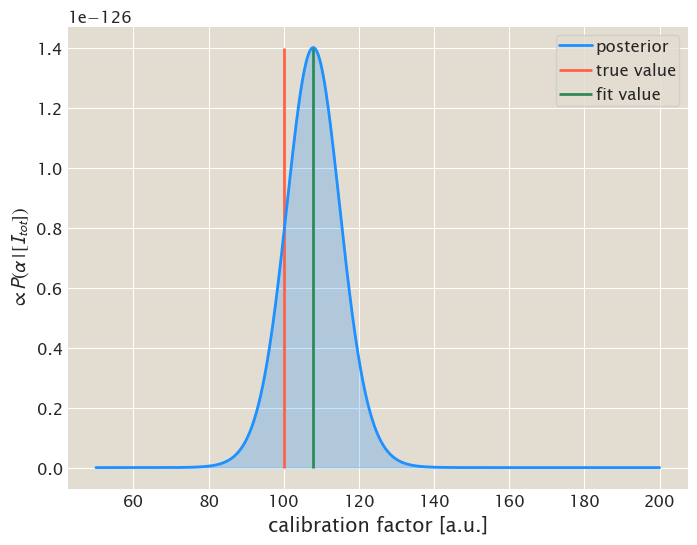

In [311]:
# Evaluate the posterior over a range of calibration factor values.
alpha_range = np.linspace(50, 200, 1000)
post = np.empty_like(alpha_range)
for i, a in enumerate(alpha_range):
    post[i] = log_posterior(a, mean_sq_diff, mean_summed, neg=False)
    
# Set up the plotting canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u.]')
ax.set_ylabel(r'$\propto P(\alpha\,\vert\,[I_{tot}])$')

# Plot the fit.
_ = ax.plot(alpha_range, np.exp(post), color='dodgerblue', lw=2, label='posterior')
_ = ax.fill_between(alpha_range, np.zeros_like(post), np.exp(post), color='dodgerblue',
                    alpha=0.25)

# Plot the fit and true value.
_ = ax.vlines(alpha_seed, 0, np.max(np.exp(post)), color='tomato', label='true value')
_ = ax.vlines(alpha_opt, 0, np.max(np.exp(post)), color='seagreen', label='fit value')


# Add a legend.
_ = ax.legend()

The posterior is sharply peaked, but not exactly at the true value. Where this is peaked will be dependent on the number of bins used to compute the means and the noisiness of the data. To find the exact peak, we can minimize the log posterior given the data. 

The shape of this posterior (by eye) looks approximately Gaussian. To get a measure of our statistical error, we can approximate this poseterior as a Gaussian and estimate the mean and variance. To do so, we can perform a Taylor expansion of our posterior about the best-fit value,

$$
\ln P(\alpha\, \vert \, [I_\text{tot}]) \approx \ln P(\alpha^*\, \vert\, [I_\text{tot}])  + {d^2 \over d \alpha^2}\ln P(\alpha^*\,\vert\, [I_\text{tot}]) \rvert_{\alpha^*}(\alpha - \alpha^*)^2.
\tag{18}
$$

We can numerically approximate this expansion by using `numdifftools` to compute the Hessian, which is the matrix of the second derivatives. In this case, it will contain a single element. 

In [312]:
# Compute the Hessian.
hess = nd.approx_hess([alpha_opt], log_posterior, args=(mean_sq_diff, mean_summed, False))
cov = -np.linalg.inv(hess)[0]
std_dev = np.sqrt(cov)[0]
print("The standard deviation of the Gaussian approximation is {0:0.1f} a.u.".format(std_dev))

The standard deviation of the Gaussian approximation is 7.1 a.u.


To see how well this approximation holds, we can plot the evaluated posterior and the Gaussian approximation together. 

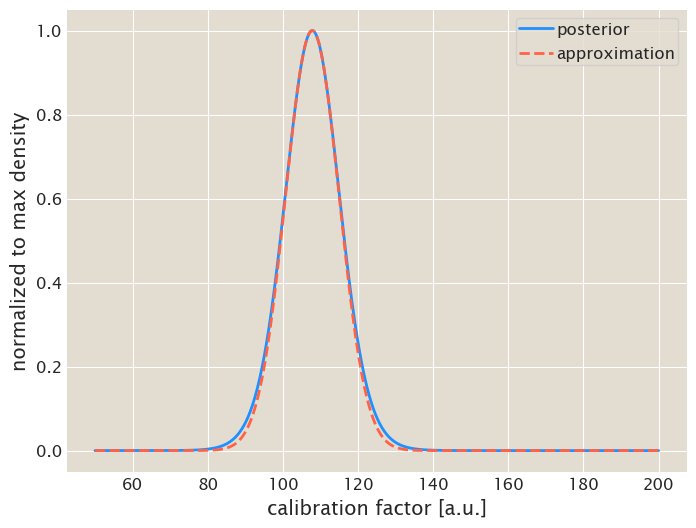

In [313]:
# Compute the gaussian approximation.
approx_fit = scipy.stats.norm(loc=alpha_opt, scale=std_dev).pdf(alpha_range)

# Plot the posterior and the approximation together.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u.]')
ax.set_ylabel('normalized to max density')
_ = ax.plot(alpha_range, np.exp(post)/np.max(np.exp(post)), '-', color='dodgerblue', label='posterior')
_ = ax.plot(alpha_range, approx_fit/np.max(approx_fit), '--', color='tomato', label='approximation')
_ = ax.legend()

While not perfect, this approximation seems to be fair. 

Note that this complete analysis was performed using the means computed from bins of 50 events. This was totally arbitrary, so how do we know which bin number is the most appropriate? To get a sense of this, we can perform this procedure over a range of bin widths from very small to very large and compare it with the true value. 

In [314]:
def compute_stats(args, fun):
    """
    Computes the best-fit value and the standard deviation from a Gaussian approximation
    of the posterior.
    
    Parameters
    ----------
    args: tuple of nd-arrays or a pandas Series
        Arguments for the log posterior function. This should not include the keyword
        argument for neg.
    fun : function
        The name of the log posterior function.
        
    Returns
    -------
    alpha_opt, std_dev : floats
        The best-fit value of the minimization and the standard deviation of the
        Gaussian approximation. 
    """
    
    # Find the optimal alpha value
    popt = scipy.optimize.minimize_scalar(fun, args=(args[0], args[1], True))
    alpha_opt = popt.x 
    
    # Compute the hessian
    hess_args = list(args)
    hess_args.append(False)
    hess = nd.approx_hess([alpha_opt], fun, args=(args[0], args[1], False))
    cov = -np.linalg.inv(hess)[0]
    std_dev = np.sqrt(cov)[0]
    return [alpha_opt, std_dev]

In [315]:
# Choose a range  of bins.
bins = np.arange(1, len(sorted_data), 10)
alpha_fits, alpha_stds = np.zeros_like(bins), np.zeros_like(bins)

# Loop through each bin width and perform the analysis.
for i, b in enumerate(bins):
    
    # Bin the data
    mean_sq, mean_sum = binning_mean(sorted_data, b)
    
    # Compute the stats.
    _opt, _std = compute_stats((mean_sq, mean_sum), log_posterior)
    alpha_fits[i] = _opt
    alpha_stds[i] = _std


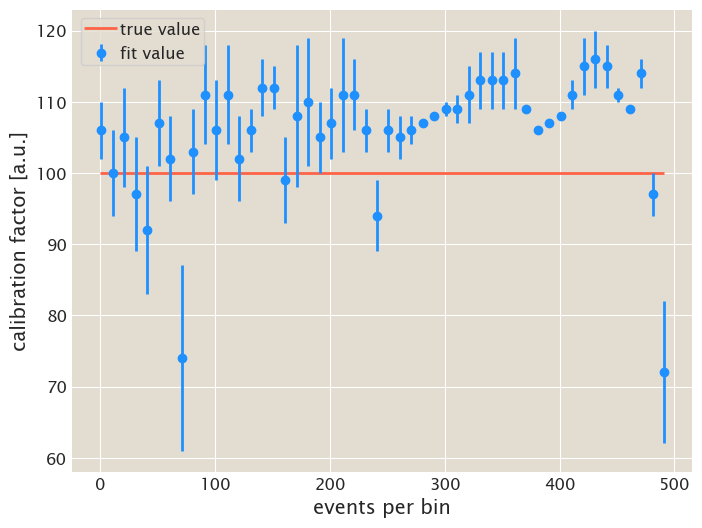

In [316]:
# Plot the fits vs the true value for each bin.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('events per bin')
ax.set_ylabel('calibration factor [a.u.]')

# Plot the results 
_ = ax.hlines(alpha_seed, 0, np.max(bins),  color='tomato', label='true value')
# _ = ax.plot(bins, alpha_fits, 'o', color='dodgerblue', label='fit value')
_ = ax.errorbar(bins, alpha_fits, alpha_stds, fmt='o', linestyle='none', color='dodgerblue',
               label='fit value')
_ = ax.legend()

As the number of bins increases, we (typically) see a shrinking statistical error bar, but the values stray far from the true value. This is one of the inherent problems with this binning technique as it will depend on the fairness of the bin used.  

###  A deterministic approach

There is a way in which the parameter can be estimated without relying on bins, yet makes the same simplifying assumption of the previous approach that the error in measurement is negligible. In this approach, we will not compute any means. Rather, we will use our knowledge of the binomial partitioning to derive the posterior.

Given the intensity measurements for the cell division events, we can write Bayes' theorem as 

$$
P(\alpha\, \vert \, I_1, I_2) \propto P(I_1, I_2 \,\vert\, \alpha) P(\alpha).
\tag{19}
$$

As we know that $I_2$ is related to $I_1$ from Eq. 1, we can simplify the likelihood in Eq. 19 as

$$
P(\alpha \, \vert \, I_1, I_2) \propto P(I_1\, \vert\, I_2, \alpha) P(I_2 \, \vert\, \alpha) P(\alpha).
\tag{20}
$$

We can treat the priors $P(I_2 \,\vert\, \alpha)$ and $P(\alpha)$ as improper uniform (as they could be anything), our posterior becomes proportional to our likelihood. We now need to develop a statistical model that describes the intensity of one daughter cell given the other intensity and a calibration factor. While this is not necessarily obvious, we know the statistical model for the partitioning of the *proteins* should be binomial. Through change of variables, we can rewrite our likelihood in terms of protein copy number as

$$
P(I_1\,\vert\, I_2, \alpha) = P(N_1\,\vert\, \alpha) \left\vert {dN_1 \over dI_1} \right\vert.
\tag{21}
$$

Given Eq. 2, the derivative in Eq. 21 can be calculated as 

$$
{dN_1 \over dI_1} = {d \over dI_1} {I_1 \over \alpha} = {1 \over \alpha}.
\tag{22}
$$

Our likelihood can now be written as

$$
P(\alpha\,\vert\, I_1, I_2) = {1 \over \alpha} P(N_1\,\vert\, I_2, \alpha).
\tag{23}
$$

As $N_1$ is Binomially distributed from a pool $N_\text{tot}$,  the likelihood becomes

$$
P(N_1 \,\vert\, I_2, \alpha) = {1\over \alpha}{N_\text{tot}! \over N_1! N_2!}p^{N_1}(1 - p)^{N_2}
\tag{24}
$$.

If we take the determinstic result that

$$
N_1 = {I_1 \over \alpha},
\tag{25}
$$

and taking partitioning to be fair ($p = 0.5$), the posterior becomes

$$
P(\alpha\,\vert\,I_1, I_2) = {1 \over \alpha}{{I_1 + I_2 \over \alpha}! \over {I_1 \over \alpha}! {I_2 \over \alpha}!}2^{-{I_1 + I_2 \over \alpha}}.
\tag{26}
$$

The factorials in Eq. 26 are a little weird as the intensity is not a discrete quantity. However, these factorials can be approximated through gamma functions as

$$
n! \approx n\Gamma(n) = \Gamma(n + 1).
\tag{27}
$$

Applying Eq. 27 to Eq. 26, our complete and final posterior for a full set of cell divisions is 

$$
P(\alpha\, \vert \, [I_1, I_2]) \propto \alpha^{-k}\prod\limits_i^k{\Gamma({I_{1,i} + I_{2,i} \over \alpha} + 1) \over \Gamma({I_{1,i} \over \alpha} + 1) \Gamma({I_{2, i} \over \alpha} + 1)}2^{-{I_{1, i} + I_{2, i} \over \alpha}}.
\tag{28}
$$

Since we have an analytical solution for the posterior, we don't need to rely on MCMC or other sampling methods to estimate the best-fit parameter for $\alpha$. Even better, this approach requires no dependence on how we bin the data!

Below, we write a function that will compute this posterior much in the spirit of the linear regression log posterior.

In [317]:
def deterministic_log_posterior(alpha, I_1, I_2, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2 : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    
    # Ensure that the intensity values are not negative.
    if (I_1 < 0).any() or (I_2 < 0).any():
        return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if alpha < 0:
        return -np.inf
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha
    n_2 = I_2 / alpha
    n_tot = n_1 + n_2
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
    
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
        
    return prefactor * lp

Using the same approach as for the linear regression, this posterior can be minimized and evaluated over a range of values for $\alpha$. 

In [318]:
# Minimize the log posterior and find the optimal value for alpha
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(df['I_1'].values, df['I_2'].values, True))
alpha_opt = popt.x
print('The best fit value for α is {0:0.1f} a.u.'.format(alpha_opt))

The best fit value for α is 108.4 a.u.


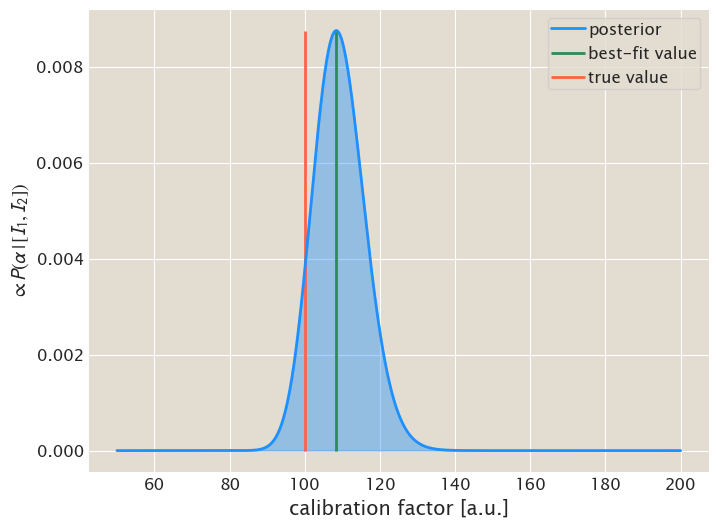

In [325]:
# Evaluate the log poseterior over a range of values for alpha.
log_post = np.empty_like(alpha_range)
for i, a in enumerate(alpha_range):
    log_post[i] = deterministic_log_posterior(a, df['I_1'], df['I_2'], False)

# Normalize the log posterior
log_post += np.abs(np.min(log_post))
log_post = np.exp(log_post) / np.exp(log_post).sum()
# Set up the figure canvas
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u.]')
ax.set_ylabel(r'$\propto P(\alpha\,\vert\, [I_1, I_2])$')

# Plot the evaluated posterior
_ = ax.plot(alpha_range, log_post, '-', lw=2, color='dodgerblue', label='posterior')
_ = ax.fill_between(alpha_range, 0, log_post, color='dodgerblue', alpha=0.4)

# Plot the best-fit value.
_ = ax.vlines(alpha_opt, 0, np.max(log_post), color='seagreen', label='best-fit value')

# Plot the true value. 
_ = ax.vlines(alpha_seed, 0, np.max(log_post), color='tomato', label='true value')

# Add a legend
_ = ax.legend()

This result is quite comparable to the example of binning with 50 events, but is less biased as it requires no binning. We are still very close to the true value! As we did previously, we can approximate this posterior as a gaussian by expanding about the peak and approximating a standard deviation for a measure of statistical error. 

In [326]:
# Approximate as a Gaussian.
hess = nd.approx_hess([alpha_opt], deterministic_log_posterior, args=(df['I_1'], df['I_2'], False))
cov = -np.linalg.inv(hess)[0]
std_dev = np.sqrt(cov)[0]
print('The best-fit value for α is {0:0.1f} +- {1:0.1f} a.u.'.format(alpha_opt, std_dev))

The best-fit value for α is 108.4 +- 6.8 a.u.


As a sanity check, we can test the accuracy of this approximation by plotting the Gaussian over the posterior. 


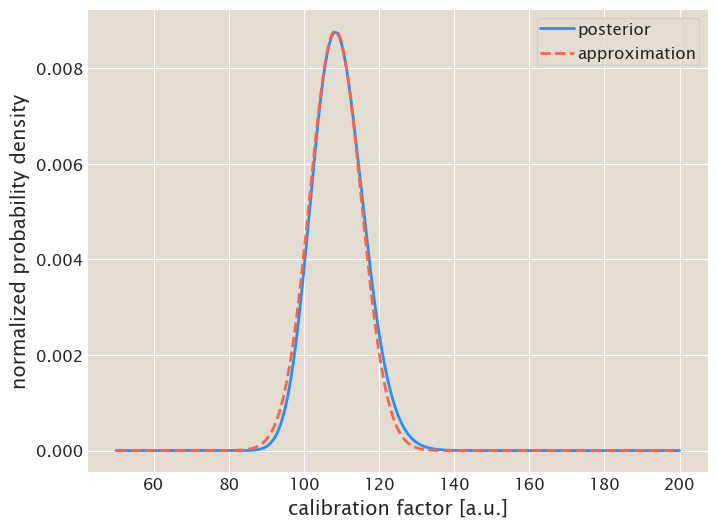

In [330]:
# Define the Gaussian.
approx = scipy.stats.norm(loc=alpha_opt, scale=std_dev).pdf(alpha_range)
approx = approx / approx.sum()

# Plot the normalized posterior and the approximation.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u.]')
ax.set_ylabel('normalized probability density')
_ = ax.plot(alpha_range, log_post, color='dodgerblue', lw=2, label='posterior')
_ = ax.plot(alpha_range, approx, '--', color='tomato', lw=2, label='approximation')
_ = ax.legend()

Again, this seems to be a very fair approximation.  

### Plotting the best-fit values 

As a sanity check, we can plot the simulated data, the range of curves from the binning procedure, and the curve from the deterministic solution to see how well they agree. 

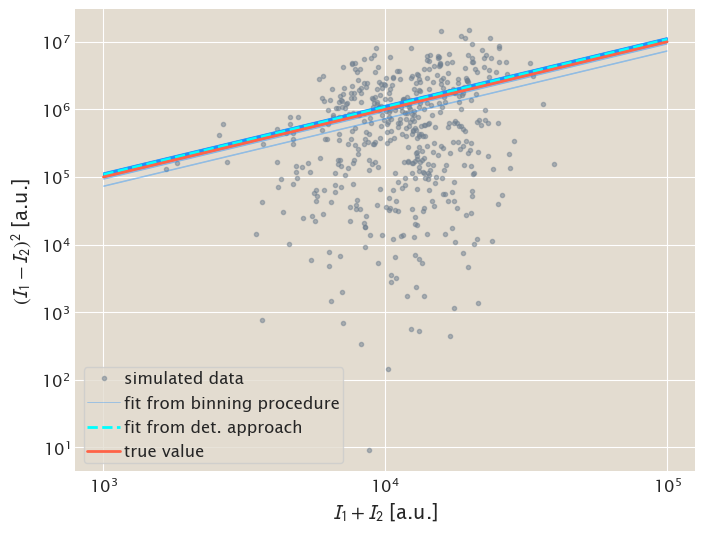

In [336]:
# Set up the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
ax.set_xscale('log')
ax.set_yscale('log')

# Plot the simulated data.
_ = ax.plot(df['summed_int'], df['square_diff'], '.', color='slategray', label='simulated data',
           alpha=0.5)

# Plot the fits from the binning procedure.
for i, a in enumerate(alpha_fits):
    fit = a * I_tot_range
    if i==0:
        label='fit from binning procedure'
    else:
        label='__nolegend__' 
    _ = ax.plot(I_tot_range, fit, color='dodgerblue', lw=0.5, alpha=0.5, label=label)
    
# Plot the fit from the deterministic approach.
deterministic_fit = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, deterministic_fit, '--', lw=2, color='cyan', label='fit from det. approach')

# Plot the true fit. 
_ = ax.plot(I_tot_range, alpha_seed * I_tot_range, color='tomato', label='true value')

# Add a legend
_ = ax.legend()

They all seem to agree with the true value except for the obvious outlier from the binnin gprocedure. We can zoom in on a zone in the middle to more clearly see the difference. 

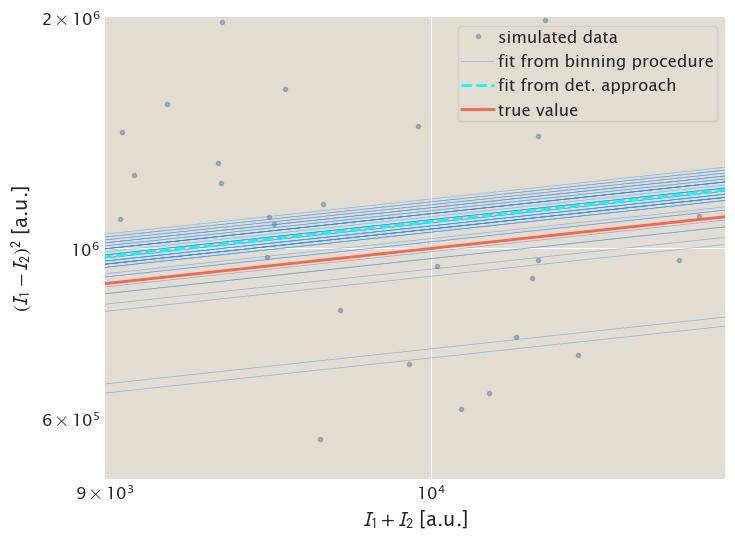

In [339]:
# Set up the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
ax.set_xscale('log')
ax.set_yscale('log')

# Plot the simulated data.
_ = ax.plot(df['summed_int'], df['square_diff'], '.', color='slategray', label='simulated data',
           alpha=0.5)

# Plot the fits from the binning procedure.
for i, a in enumerate(alpha_fits):
    fit = a * I_tot_range
    if i==0:
        label='fit from binning procedure'
    else:
        label='__nolegend__' 
    _ = ax.plot(I_tot_range, fit, color='dodgerblue', lw=0.5, alpha=0.5, label=label)
    
# Plot the fit from the deterministic approach.
deterministic_fit = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, deterministic_fit, '--', lw=2, color='cyan', label='fit from det. approach')

# Plot the true fit. 
_ = ax.plot(I_tot_range, alpha_seed * I_tot_range, color='tomato', label='true value')

# Add a legend
_ = ax.legend()

# Zoom in on only one small range.
_ = ax.set_xlim([9E3, 1.1E4])
_ = ax.set_ylim([5E5, 2E6])